/Users/alecpanattoni/Documents/MissingnessFairnessAnalysis/src/data_generation.py:184: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['a', 'b', 'c', 'd'])
/Users/alecpanattoni/Documents/MissingnessFairnessAnalysis/src/data_generation.py:185: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+['e', 'f', 'g', 'h'])


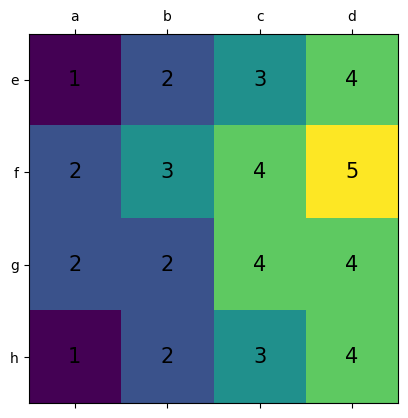

/Users/alecpanattoni/Documents/MissingnessFairnessAnalysis/src/data_generation.py:202: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['insert', 'fairness', 'notions', 'here'])
/Users/alecpanattoni/Documents/MissingnessFairnessAnalysis/src/data_generation.py:203: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+['No Missing', 'MCAR', 'MAR', 'NMAR'])


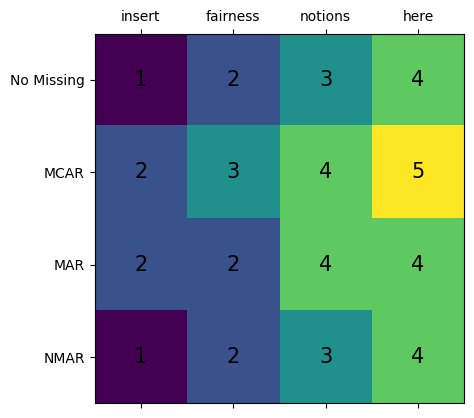

pip install 'aif360[LawSchoolGPA]'


In [1]:
import os
import sys
from src.cleaning import datacleaning
from src import data_generation
from src.preparation import model_perform
import pandas as pd
import numpy as np
import aif360
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from aif360.sklearn.metrics import statistical_parity_difference
from aif360.sklearn.metrics import average_odds_difference
from aif360.sklearn.metrics import equal_opportunity_difference

In [2]:
data = datacleaning.cleaning(os.path.join(os.path.dirname(
    os.path.realpath('run.py')) + '/data/allegations_raw.csv'))

In [3]:
target = sys.argv[1]

if target == "test":
    data = datacleaning.cleaning(os.path.join(os.path.dirname(
        os.path.realpath('run.py')) + '/data/test.csv'))

if target == "all":
    data = datacleaning.cleaning(os.path.join(os.path.dirname(
        os.path.realpath('run.py')) + '/data/allegations_raw.csv'))

In [4]:
data.isna().sum()

complainant_age_incident    0
allegation                  0
contact_reason              0
substantiated               0
complainant_gender          0
dtype: int64

In [5]:
data.head()

,complainant_age_incident,allegation,contact_reason,substantiated,complainant_gender
0,38.0,Failure to provide RTKA card,Report-domestic dispute,True,Female
1,26.0,Action,Moving violation,True,Male
2,26.0,Race,Moving violation,True,Male
3,45.0,Question,PD suspected C/V of violation/crime - street,True,Male
5,31.0,Refusal to process civilian complaint,C/V telephoned PCT,True,Male


In [6]:
train, test = train_test_split(data, train_size=0.8)

## Missingness Creation

We want the attribute with missingness to have around the same proportion of missingness for each type. This is because we don't want the amount of missingness to be a confounding factor in our results.

In [7]:
t = train.copy()
mcar = data_generation.mcar(t, 'complainant_age_incident', 0.5)

/Users/alecpanattoni/Documents/MissingnessFairnessAnalysis/src/data_generation.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[column].iloc[i] = np.nan


In [8]:
mcar['complainant_age_incident'].isna().sum() / mcar.shape[0]

0.5017646020822305

In [9]:
mcar = mcar.dropna(subset = 'complainant_age_incident')

For MAR, we want to try to find attributes that are, ideally, highly correlated with both the sensitive attribute and the label outcome attribute. Let's first look into the complainant age attribute.

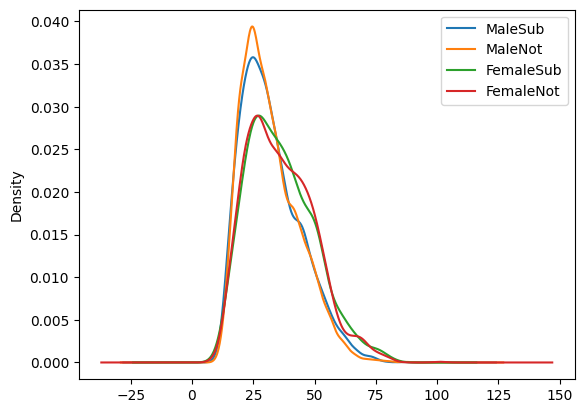

In [10]:
for gender in ['Male', 'Female']:
    for sub in [True, False]:
        data[(data['complainant_gender'] == gender) & (
            data['substantiated'] == sub)]['complainant_age_incident'].plot(kind='density', legend=True)
    plt.legend(['MaleSub', 'MaleNot', 'FemaleSub', 'FemaleNot'])

It looks like complainant age is only highly correlated with the sensitive attribute, and not the outcome label. This will still work with the goal we have in mind, though. 

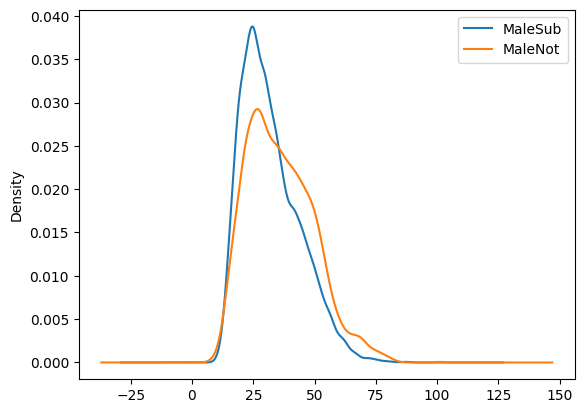

In [11]:
for gender in ['Male', 'Female']:
    data[(data['complainant_gender'] == gender)]['complainant_age_incident'].plot(kind='density', legend=True)
plt.legend(['MaleSub', 'MaleNot', 'FemaleSub', 'FemaleNot'])

In order to add to the noticeability of MAR (where each category of our sensitive attribute has a different amount of missinness) we will only apply MAR missingness to the underprivileged group (females). Non-MAR missingness can be added to the privileged group to see how different types of missingness produce differences among the sensitive attribute.

In [12]:
t = train.copy()
male = data_generation.mcar(t[t['complainant_gender'] == 'Male'], 'complainant_age_incident', 0.5)
female = data_generation.mar(t[t['complainant_gender'] == 'Female'],
                             'complainant_age_incident', 'complainant_gender', 0.8)
for idx, i in enumerate(female.iterrows()):
    # if S = 0 & Y = 1, add additional probability of missingness
    if (i[1]['substantiated'] == True) and (i[1]['complainant_gender'] == 'Female'):
        if np.random.choice([1, 0], p = [0.7, 0.3]) == 1:
            female['complainant_gender'].iloc[idx] = np.nan
mar = pd.concat([male, female])
mar

/Users/alecpanattoni/Documents/MissingnessFairnessAnalysis/src/data_generation.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[column].iloc[i] = np.nan
/Users/alecpanattoni/Documents/MissingnessFairnessAnalysis/src/data_generation.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[miss_column].iloc[i] = np.nan
/var/folders/c2/wd6pf3ls7732c5mp_5vvb1cw0000gn/T/ipykernel_22286/774767909.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

,complainant_age_incident,allegation,contact_reason,substantiated,complainant_gender
28660,NaN,Gun Pointed,Report of other crime,False,Male
33188,NaN,Word,PD suspected C/V of violation/crime - street,False,Male
5497,NaN,Gun Pointed,Moving violation,False,Male
20153,NaN,Physical force,Other,False,Male
2458,NaN,Search (of person),PD suspected C/V of violation/crime - auto,False,Male
...,...,...,...,...,...
16298,NaN,Refusal to provide name/shield number,Report-dispute,True,Female
21902,23.0,Threat of arrest,PD suspected C/V of violation/crime - bldg,False,Female
14896,NaN,Strip-searched,PD suspected C/V of violation/crime - bldg,True,Female
12157,NaN,Threat of arrest,Traffic accident,False,Female


In [13]:
mar['complainant_age_incident'].isna().sum() / mar.shape[0]

0.49482850070721357

In [14]:
mar = mar.dropna(subset = 'complainant_age_incident')

In [15]:
t = train.copy()
nmar = data_generation.nmar(t, 'complainant_age_incident', 1)

/Users/alecpanattoni/Documents/MissingnessFairnessAnalysis/src/data_generation.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[column].iloc[i] = np.nan


In [16]:
nmar['complainant_age_incident'].isna().sum() / nmar.shape[0]

0.49100052938062466

In [17]:
nmar = nmar.dropna(subset = 'complainant_age_incident')

Now we will "handle" the missingness by dropping missing values.

## Applying Fairness Notions


In [18]:
cats = ["allegation", "contact_reason"]

### Calculating fairnes notions for No Missingness At All

In [19]:
#storing fairness notions for no missingness
no_missing_results = model_perform.model(train, test, cats)

2023-03-14 21:48:05.340842: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-14 21:48:05.341256: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Metal device set to: Apple M2


2023-03-14 21:48:05.533795: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled
2023-03-14 21:48:05.543614: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-14 21:48:05.552011: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-14 21:48:05.723078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-14 21:48:05.727265: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


epoch 0; iter: 0; batch classifier loss: 0.672213; batch adversarial loss: 0.698166
epoch 1; iter: 0; batch classifier loss: 0.478166; batch adversarial loss: 0.631784
epoch 2; iter: 0; batch classifier loss: 0.500271; batch adversarial loss: 0.593545
epoch 3; iter: 0; batch classifier loss: 0.493588; batch adversarial loss: 0.551416
epoch 4; iter: 0; batch classifier loss: 0.529662; batch adversarial loss: 0.513479
epoch 5; iter: 0; batch classifier loss: 0.658120; batch adversarial loss: 0.518212
epoch 6; iter: 0; batch classifier loss: 0.467646; batch adversarial loss: 0.478709
epoch 7; iter: 0; batch classifier loss: 0.587972; batch adversarial loss: 0.453766
epoch 8; iter: 0; batch classifier loss: 0.495718; batch adversarial loss: 0.396154
epoch 9; iter: 0; batch classifier loss: 0.552636; batch adversarial loss: 0.492146
epoch 10; iter: 0; batch classifier loss: 0.415332; batch adversarial loss: 0.384238
epoch 11; iter: 0; batch classifier loss: 0.517692; batch adversarial loss:

2023-03-14 21:49:21.637755: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




accuracy: 0.7586450247000706
Statistical parity: 0.03176283748014823
Equality of odds: 0.048198929076815895
Equality of opportunity: 0.08110014104372355


### Fairness notions for NMAR

In [20]:
nmar_results = model_perform.model(nmar, test, cats)

2023-03-14 21:49:22.086534: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-14 21:49:22.086605: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-03-14 21:49:22.302186: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-14 21:49:22.353528: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-14 21:49:22.356677: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


epoch 0; iter: 0; batch classifier loss: 1.330552; batch adversarial loss: 0.694707
epoch 1; iter: 0; batch classifier loss: 0.689828; batch adversarial loss: 0.651442
epoch 2; iter: 0; batch classifier loss: 0.604424; batch adversarial loss: 0.627864
epoch 3; iter: 0; batch classifier loss: 0.576617; batch adversarial loss: 0.611032
epoch 4; iter: 0; batch classifier loss: 0.548498; batch adversarial loss: 0.588470
epoch 5; iter: 0; batch classifier loss: 0.497491; batch adversarial loss: 0.558707
epoch 6; iter: 0; batch classifier loss: 0.580938; batch adversarial loss: 0.568453
epoch 7; iter: 0; batch classifier loss: 0.499942; batch adversarial loss: 0.534274
epoch 8; iter: 0; batch classifier loss: 0.425177; batch adversarial loss: 0.502639
epoch 9; iter: 0; batch classifier loss: 0.510642; batch adversarial loss: 0.499079
epoch 10; iter: 0; batch classifier loss: 0.494095; batch adversarial loss: 0.460816
epoch 11; iter: 0; batch classifier loss: 0.454057; batch adversarial loss:

2023-03-14 21:50:03.554204: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.




accuracy: 0.7597035991531405
Statistical parity: 0.031056996647256044
Equality of odds: 0.047963164650705166
Equality of opportunity: 0.08180535966149506


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Fairness notions for MCAR

In [21]:
mcar_results = model_perform.model(mcar, test, cats)

2023-03-14 21:50:03.976406: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-14 21:50:03.976422: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-03-14 21:50:04.260683: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-14 21:50:04.300801: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-14 21:50:04.304001: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


epoch 0; iter: 0; batch classifier loss: 0.689166; batch adversarial loss: 0.681651
epoch 1; iter: 0; batch classifier loss: 0.537903; batch adversarial loss: 0.662612
epoch 2; iter: 0; batch classifier loss: 0.477994; batch adversarial loss: 0.626578
epoch 3; iter: 0; batch classifier loss: 0.506512; batch adversarial loss: 0.611257
epoch 4; iter: 0; batch classifier loss: 0.445722; batch adversarial loss: 0.584570
epoch 5; iter: 0; batch classifier loss: 0.504032; batch adversarial loss: 0.558229
epoch 6; iter: 0; batch classifier loss: 0.532278; batch adversarial loss: 0.496424
epoch 7; iter: 0; batch classifier loss: 0.500541; batch adversarial loss: 0.527643
epoch 8; iter: 0; batch classifier loss: 0.454083; batch adversarial loss: 0.533715
epoch 9; iter: 0; batch classifier loss: 0.541922; batch adversarial loss: 0.507938
epoch 10; iter: 0; batch classifier loss: 0.521239; batch adversarial loss: 0.560842
epoch 11; iter: 0; batch classifier loss: 0.554654; batch adversarial loss:

2023-03-14 21:50:39.979804: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




accuracy: 0.7575864502470007
Statistical parity: 0.048703017469560614
Equality of odds: 0.07006776007363882
Equality of opportunity: 0.11283497884344147


### Fairness notions for MAR

In [22]:
mar_results = model_perform.model(mar, test, cats)

2023-03-14 21:50:40.355405: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-14 21:50:40.355449: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-03-14 21:50:40.537267: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-14 21:50:40.581164: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-14 21:50:40.585830: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


epoch 0; iter: 0; batch classifier loss: 1.031142; batch adversarial loss: 1.282617
epoch 1; iter: 0; batch classifier loss: 1.417158; batch adversarial loss: 1.511104
epoch 2; iter: 0; batch classifier loss: 1.124770; batch adversarial loss: 1.324874
epoch 3; iter: 0; batch classifier loss: 1.458017; batch adversarial loss: 1.276085
epoch 4; iter: 0; batch classifier loss: 1.378451; batch adversarial loss: 1.127529
epoch 5; iter: 0; batch classifier loss: 1.524354; batch adversarial loss: 1.035249
epoch 6; iter: 0; batch classifier loss: 1.525398; batch adversarial loss: 0.922759
epoch 7; iter: 0; batch classifier loss: 1.625570; batch adversarial loss: 0.841908
epoch 8; iter: 0; batch classifier loss: 1.753076; batch adversarial loss: 0.757987
epoch 9; iter: 0; batch classifier loss: 1.335420; batch adversarial loss: 0.705792
epoch 10; iter: 0; batch classifier loss: 1.309899; batch adversarial loss: 0.642843
epoch 11; iter: 0; batch classifier loss: 0.860906; batch adversarial loss:

2023-03-14 21:51:17.318246: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.




accuracy: 0.7567043048694425
Statistical parity: 0.0555849655902594
Equality of odds: 0.07865096275868115
Equality of opportunity: 0.12482369534555712


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
nmar.head()

,complainant_age_incident,allegation,contact_reason,substantiated,complainant_gender
28660,24.0,Gun Pointed,Report of other crime,False,Male
33188,37.0,Word,PD suspected C/V of violation/crime - street,False,Male
10475,24.0,Search (of person),Report-possession/sale of narcotics,False,Male
2748,28.0,Physical force,C/V at PCT to obtain information,False,Male
7284,38.0,Physical force,PD suspected C/V of violation/crime - bldg,False,Male


## Visualizing Our Results

In [24]:
#put our fairness statistics into arrays for future usage
acc = [no_missing_results[0],nmar_results[0],mcar_results[0],mar_results[0]]
par= [no_missing_results[1],nmar_results[1],mcar_results[1],mar_results[1]]
odds= [no_missing_results[2],nmar_results[2],mcar_results[2],mar_results[2]]
opp = [no_missing_results[3],nmar_results[3],mcar_results[3],mar_results[3]]

In [25]:
labels = ['No Missingess,', 'NMAR', 'MCAR', 'MAR']

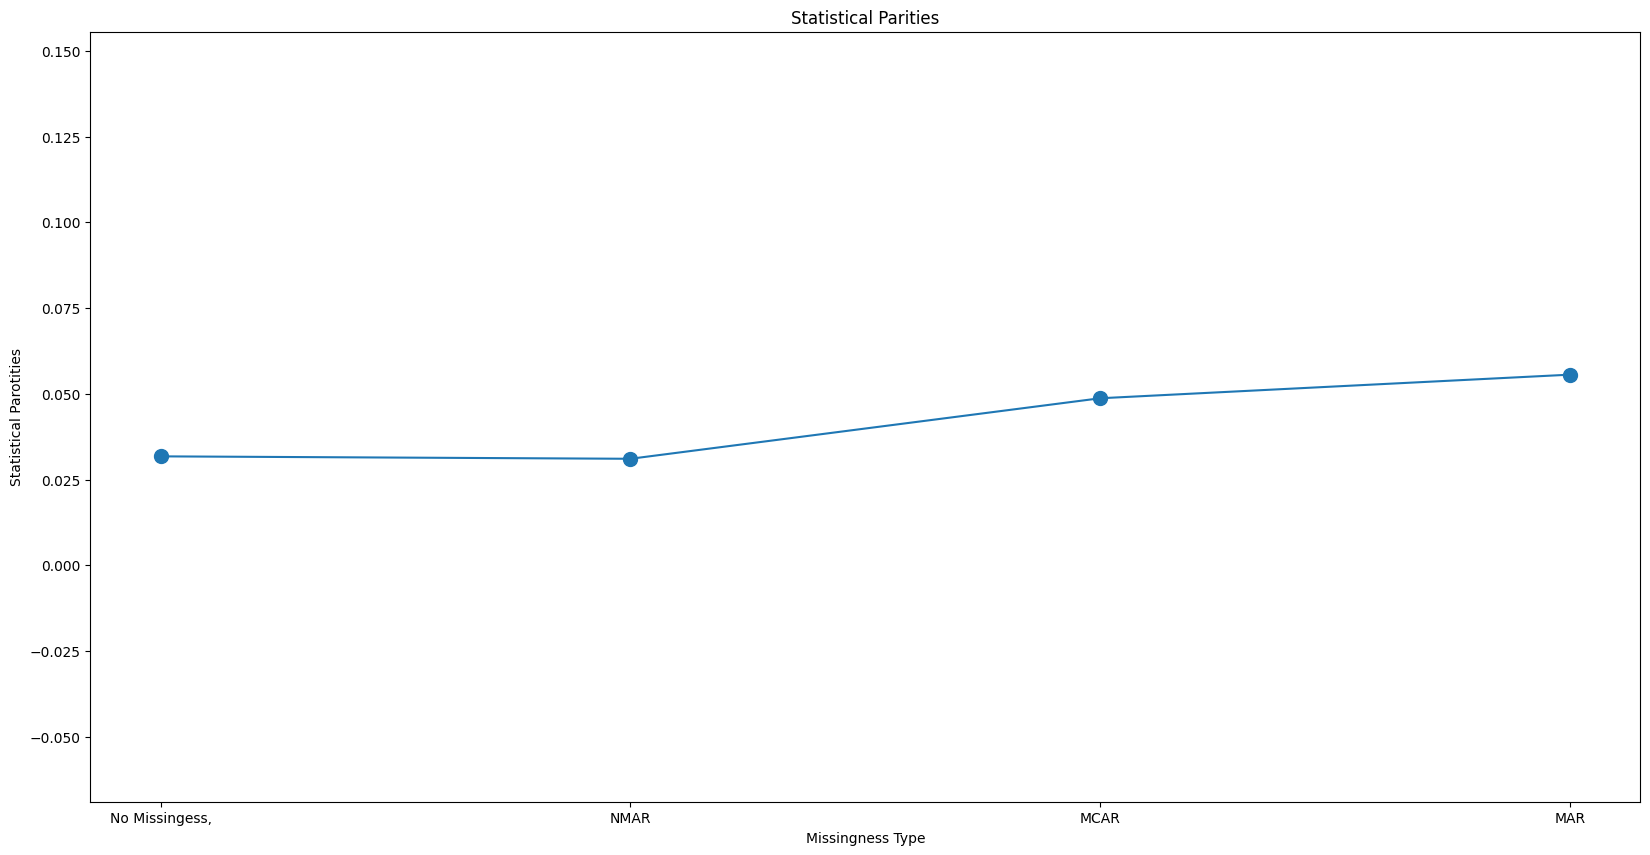

In [26]:
plt.figure(figsize = (20, 10))
plt.title('Statistical Parities')
plt.xlabel('Missingness Type')
plt.ylabel('Statistical Parotities')
plt.ylim(min(par) - 0.1, max(par) + 0.1)
plt.plot(labels, par, marker='.', markersize = 20)

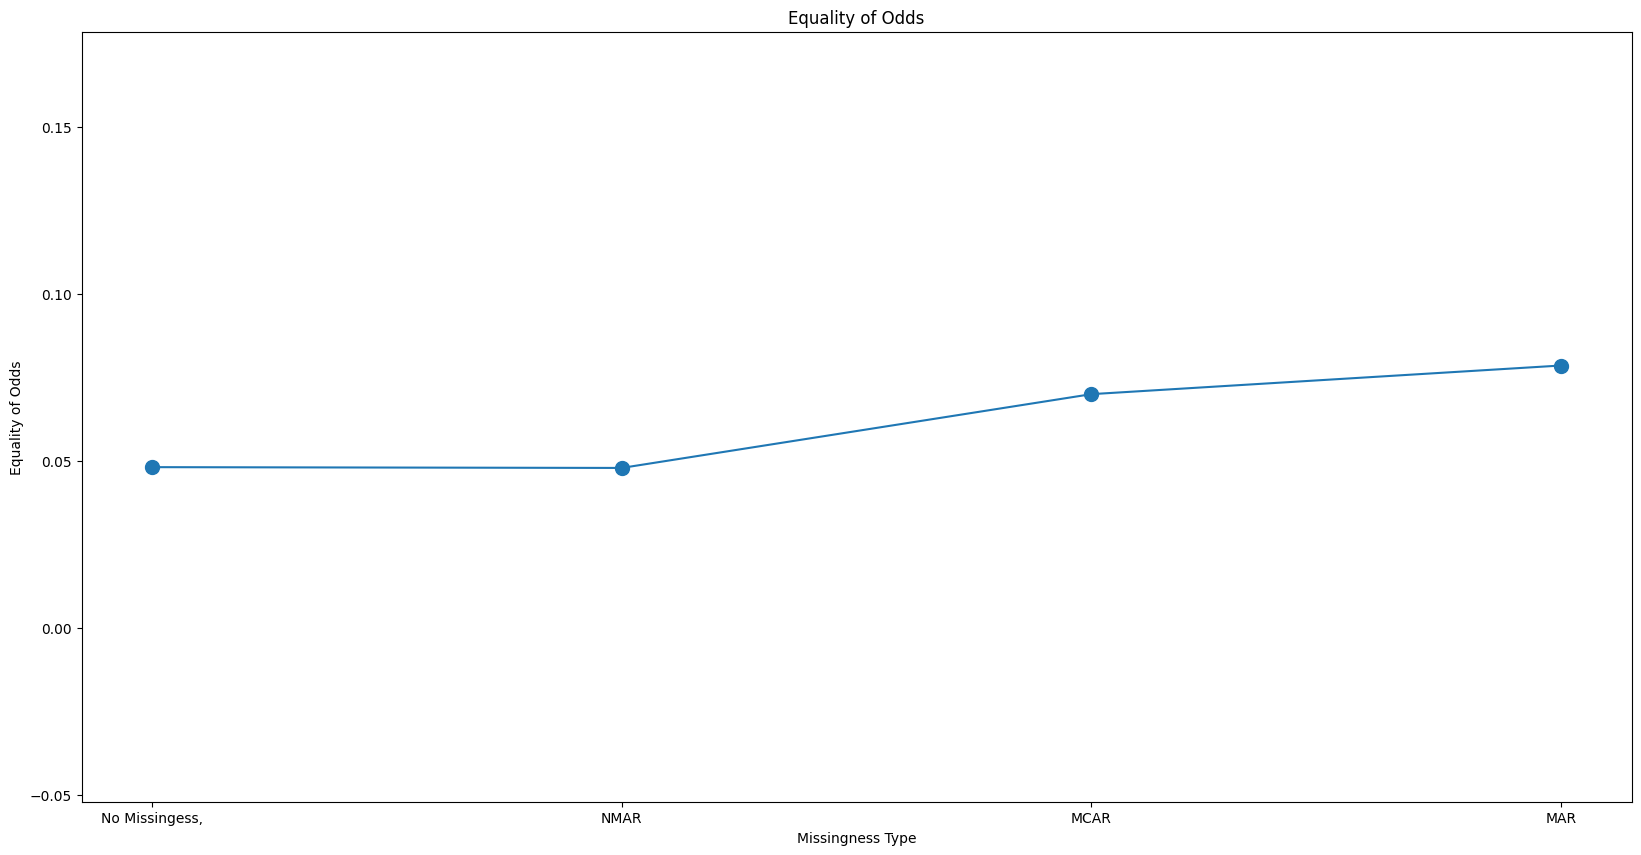

In [27]:
plt.figure(figsize = (20, 10))
plt.title('Equality of Odds')
plt.xlabel('Missingness Type')
plt.ylabel('Equality of Odds')
plt.ylim(min(odds)-0.1,max(odds) + 0.1)
plt.plot(labels, odds, marker='.', markersize = 20)

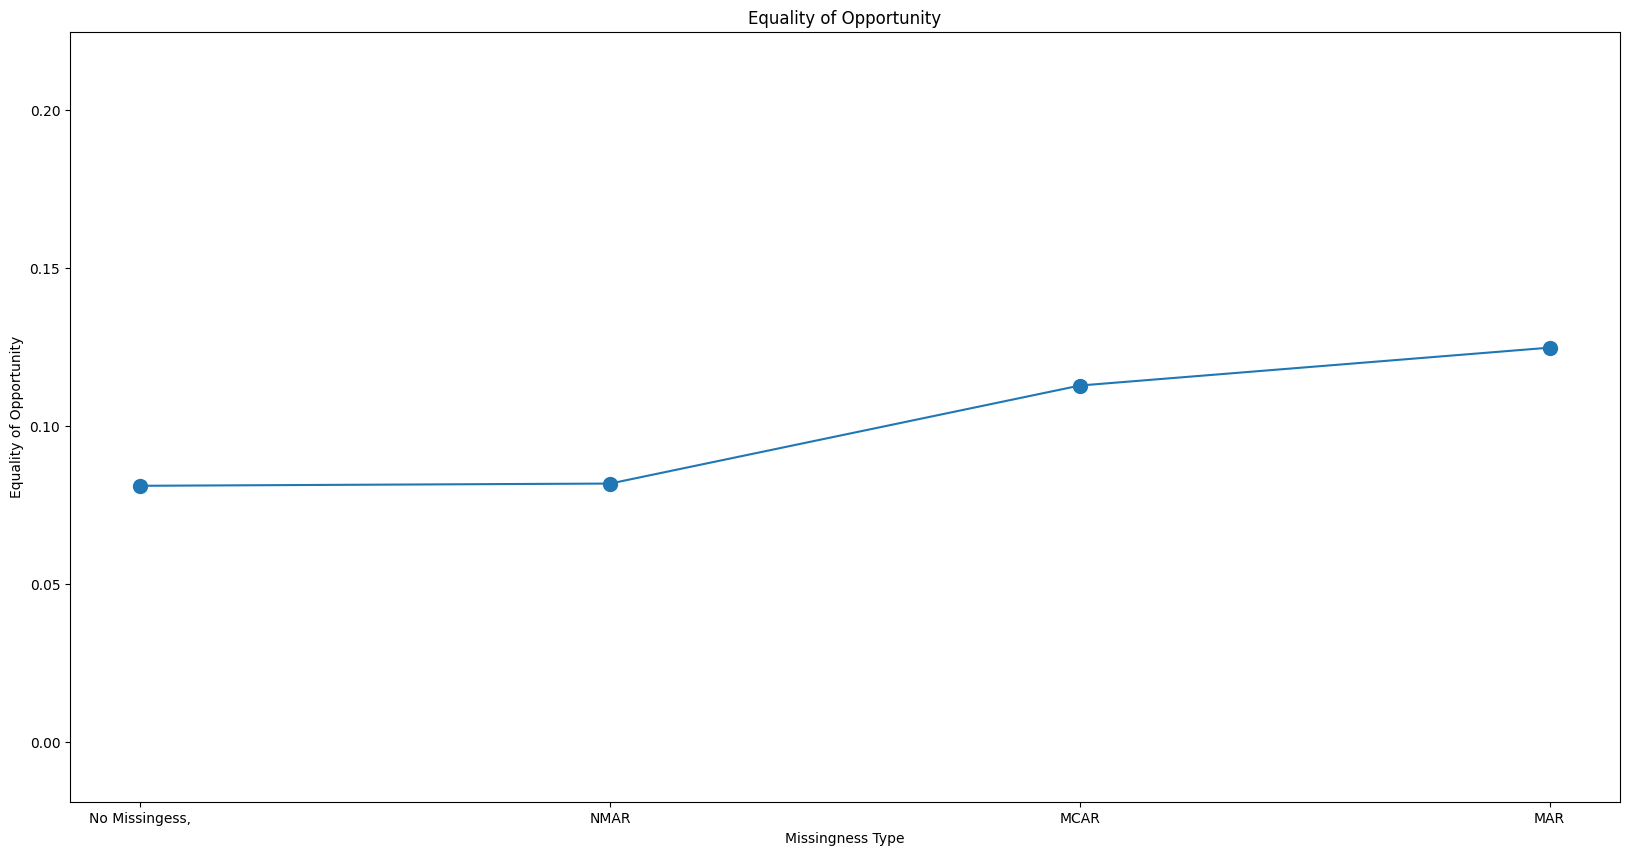

In [28]:
plt.figure(figsize = (20, 10))
plt.title('Equality of Opportunity')
plt.xlabel('Missingness Type')
plt.ylabel('Equality of Opportunity')
plt.ylim(min(opp)-0.1,max(opp) + 0.1)
plt.plot(labels, opp, marker='.', markersize = 20)

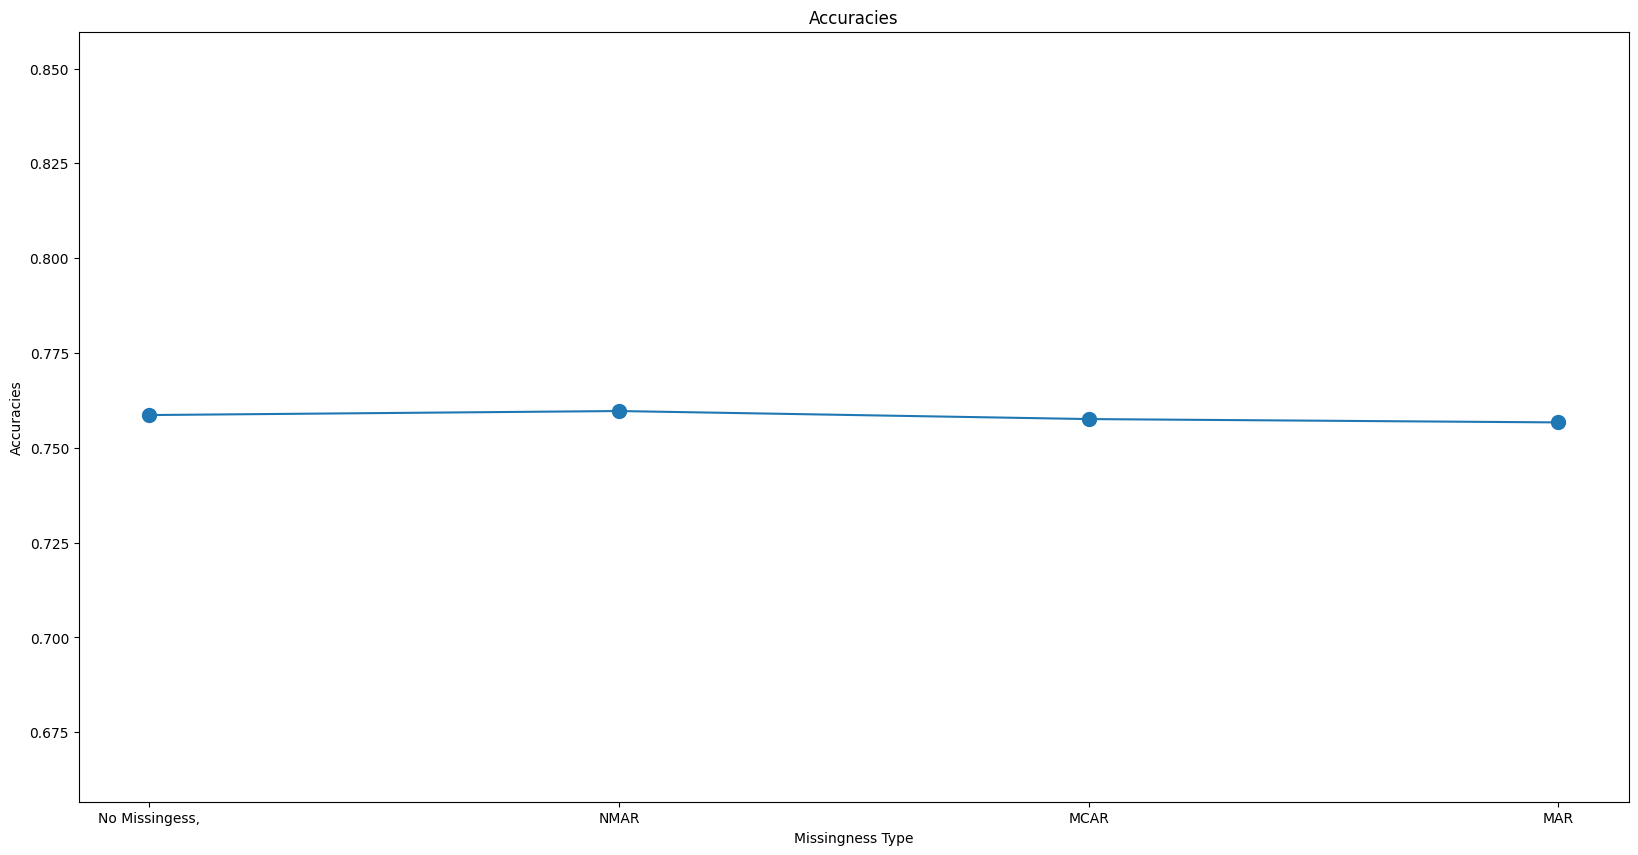

In [29]:
plt.figure(figsize = (20, 10))
plt.title('Accuracies')
plt.xlabel('Missingness Type')
plt.ylabel('Accuracies')
plt.ylim(min(acc)-0.1,max(acc) + 0.1)
plt.plot(labels, acc, marker='.', markersize = 20)